In [2]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))
import cv2
import imghdr
data_dir = 'brain/Brain_Data_Organised' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            
data = tf.keras.utils.image_dataset_from_directory('brain/Brain_Data_Organised')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Issue with image brain/Brain_Data_Organised\Normal\.ipynb_checkpoints
Issue with image brain/Brain_Data_Organised\Stroke\.ipynb_checkpoints
Found 2503 files belonging to 2 classes.


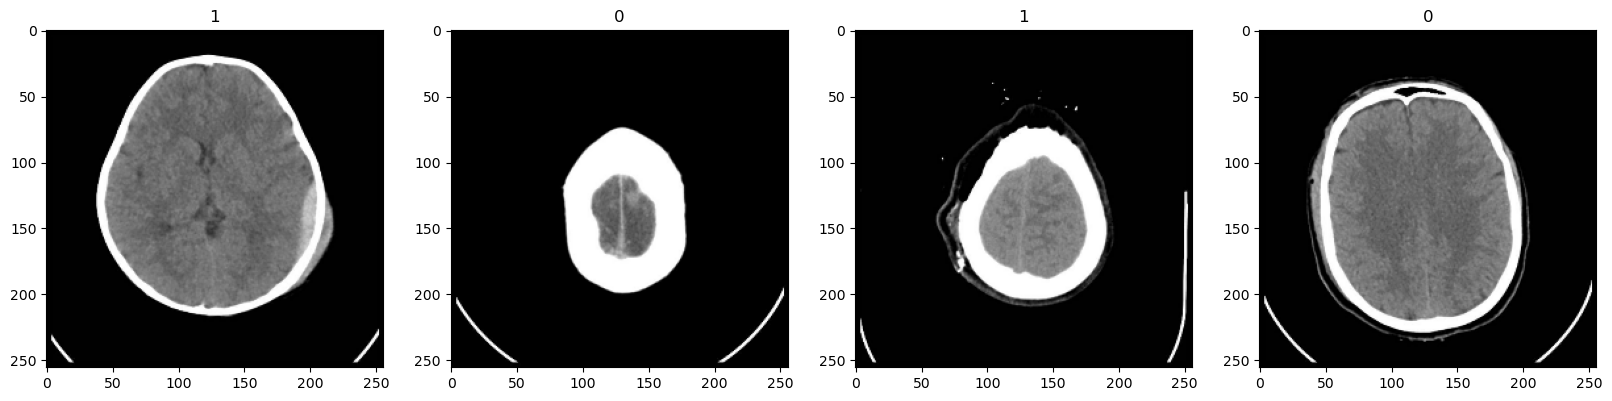

In [3]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [4]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [5]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
#  tf.optimizers.Adagrad

In [7]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [8]:
logdir='adambrain'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [9]:
hist = model.fit(train, epochs=7, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/7
55/55 [==============================] - 14s 119ms/step - loss: 0.6920 - accuracy: 0.6165 - val_loss: 0.5633 - val_accuracy: 0.7104
Epoch 2/7
55/55 [==============================] - 6s 110ms/step - loss: 0.4263 - accuracy: 0.7830 - val_loss: 0.2899 - val_accuracy: 0.8771
Epoch 3/7
55/55 [==============================] - 6s 105ms/step - loss: 0.2030 - accuracy: 0.9131 - val_loss: 0.2012 - val_accuracy: 0.9104
Epoch 4/7
55/55 [==============================] - 6s 108ms/step - loss: 0.1035 - accuracy: 0.9568 - val_loss: 0.1707 - val_accuracy: 0.9417
Epoch 5/7
55/55 [==============================] - 6s 106ms/step - loss: 0.0600 - accuracy: 0.9756 - val_loss: 0.1197 - val_accuracy: 0.9542
Epoch 6/7
55/55 [==============================] - 7s 115ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.1111 - val_accuracy: 0.9583
Epoch 7/7
55/55 [==============================] - 7s 114ms/step - loss: 0.0267 - accuracy: 0.9898 - val_loss: 0.1328 - val_accuracy: 0.9479


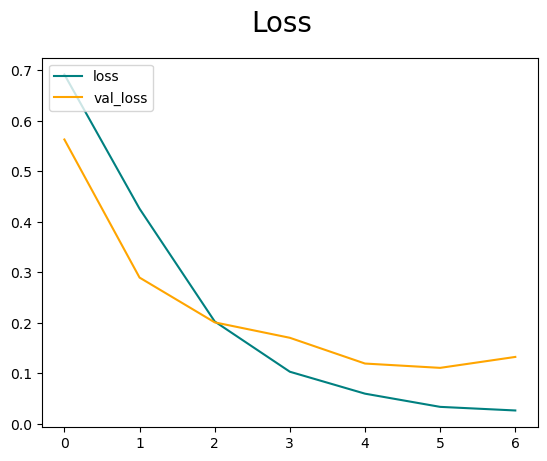

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

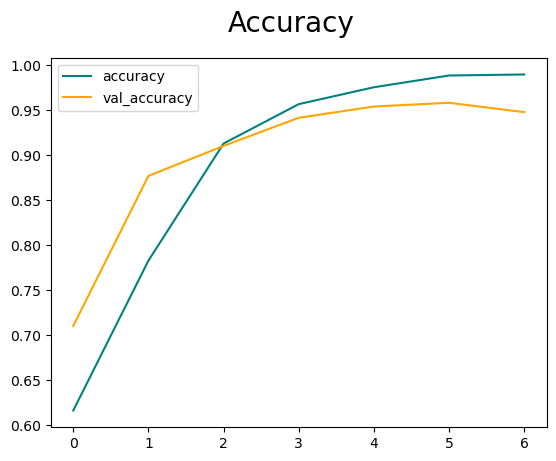

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [14]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [15]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 32ms/step


In [16]:
print(f'{pre.result()}, {re.result()}, {acc.result()}')

0.9634146094322205, 0.9404761791229248, 0.9642857313156128


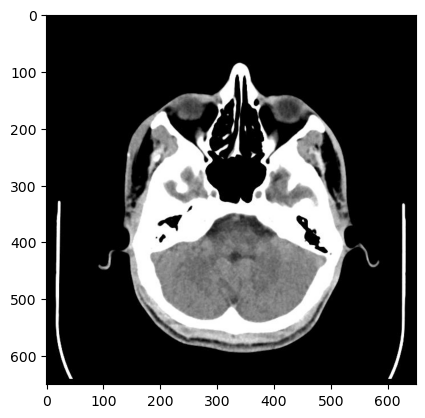

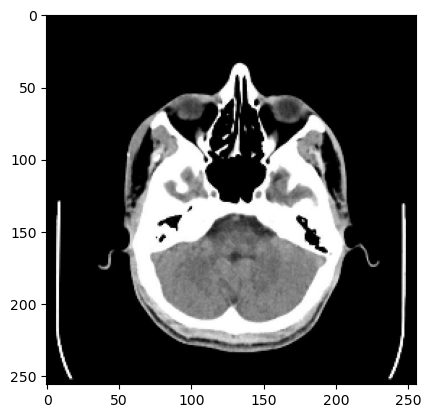

In [15]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('brain/Brain_Data_Organised/Normal/99 (8).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [16]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 460ms/step


In [17]:
yhat

array([[2.5740346e-07]], dtype=float32)

In [18]:
if yhat > 0.5: 
    print(f'Predicted class is normal')
else:
    print(f'Predicted class is stroke')

Predicted class is stroke


In [19]:

model.save(os.path.join('models','adambrain.h5'))

In [20]:
from tensorflow.keras.models import load_model
new_model = load_model('models/adambrain.h5')

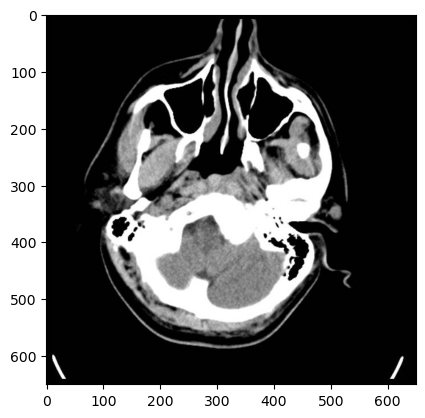

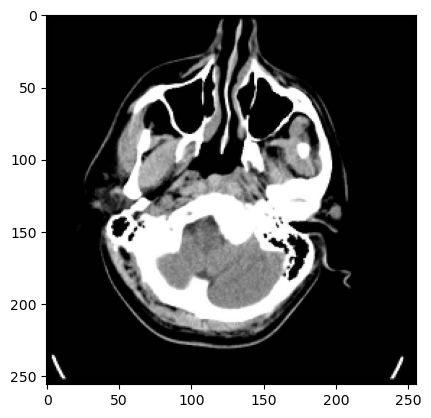

In [21]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('brain/Brain_Data_Organised/Stroke/97 (7).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [22]:
final=new_model.predict(np.expand_dims(resize/255, 0))
final

1/1 [==============================] - 0s 74ms/step


array([[0.9999622]], dtype=float32)

In [24]:
if final > 1: 
    print(f'Predicted class is normal ')
else:
    print(f'Predicted class is stroke ')

Predicted class is stroke 
